# **AM 207**: Homework 10 - Solution

Every night a drunken pixie jumps from the window of a high tower and tries to fly home. Fascinated by this behavior, you try to model the height of the pixies flight relative to the tower window with a Gaussian Process. You hire a troll to operate a large wooden wall covered with honey. You measure the elevation height of the pixie at a specific distance by letting it crush into the wall and reading the height of the pixie sticking to the honey from a measurementn tape fixed to the wall. The pixie seems to not mind this process, as it likes honey and always comes back the next night. You can see the wall for up to 18 meters away from your tower, then a mystical mist prevents you from seeing anything. 

You want to design an experiment to observe $N$ points, and make predictions about the pixie flight at $100$ locations evenly spaced on $[0,18]$ using Gaussian Processes. Here are three strategies you can use:

(1) uniformly sample $N$ points from the interval $[0, 18]$

(2) select evenly spaced $N$ points on the interval $[0, 18]$

(3) start from the the end point $18$ and sequentially add the point with the largest prediction confidence interval (largest uncertainty). If there are ties, choose the first point you encounter from the right.

The pixie flight function is: $$f(x) = x sin(x)+\mathcal{N}(\mu = 0, \sigma= 0.1x + 1)$$ defined on $[0, 18]$. As you can see the noise increases with the distance from the tower, because you get worse at reading the measurement tape. You are very aware of your limitations though and this enables you to actually know the noise distribution of your measurements. 

We use a homogeneous covariance function: an exponential kernel defined below with parameters 5, 10.

    def exponential_kernel(x_1, x_2, params): 
        return params[0] * np.exp( -0.5 * params[1] * np.sum((x_1 - x_2)**2) )
    
Assume that the standard deviations at the $100$ predicted points are $\boldsymbol{\sigma} = (\sigma_1,\ldots,\sigma_{100})$. We evaluate the goodness of the predictions based on three criterions: 

(i) sample mean $\bar{\sigma} = \sum_{i=1}^{100}\sigma_i / 100$, which characterizes the variability on average; 

(ii) the maximum value $\max\{\sigma\}= \max_{1\leq i\leq 100}\sigma_i$, which characterizes the maximum risk;

(iii) mean squared-prediction-error defined as
$$SSE = \frac{1}{100}\sum_{i=1}^{100} (f_{true}(x_i) - \hat{f}(x_i))^2,$$

where $f_{true}(x) = x sin(x)$ is the truth without noise, $\hat{f}(x_i)$ is the predicted mean value at position $x_i$ based on the Gaussian process.

(a) Please conduct simulation experiments with $N=20$ for the three strategies above. Which strategy performs best for which criterion? Discuss your results.  

(b) If you increase $N$ or decrease $N$, how does the $\bar{\sigma}$, $\max\{\sigma\}$ and $SSE$ change? Which strategy do you find is the most robust to the number of points, $N$, that you observe?

Hint: The pixie is going to be very sad if you do not provide standard deviations for your evaluations. 

Totally optional for fun:
- Think about the kernel parameters and if and how you would change them
- Instead of trying to fit the whole function, use GP to find the maximum while trying to minimize the number of wall crashes for the pixie. You can use Thompson sampling, probability of imrovement or also expected improvement and compare the different strategies. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
from IPython import display
import time

First we define some useful functions.

In [70]:
# This function computes the covariance for the GP
# as specified in the assignment above
def exponential_kernel(x_1, x_2): 
    return 5.0 * np.exp( -0.5 * 10.0 * np.sum((x_1 - x_2)**2) )

In [71]:
# Two functions for the true and the noisy pixie flight height. 
f_true = lambda x: x * np.sin(x)
f_noise = lambda x: f_true(x) + np.random.normal(loc=0, scale = 0.1*x+1)

In [72]:
# This function compute the whole covariance matrix
def get_cov_matrix(xx1,xx2):
    sigma = np.zeros((xx1.shape[0],xx2.shape[0]))
    for i in xrange(xx1.shape[0]):
        for j in xrange(xx2.shape[0]):
            sigma[i,j] = exponential_kernel(xx1[i],xx2[j])
            
    return sigma

In [73]:
# Compute the mean and variance for the conditionals
# p(f_star|x_star, x, y)
# This code uses the cholesky decomposition to 
# avoid numerical instabilities with the matrix inverse.
def get_GP_mu_and_sigma_star(x,y,x_star):
    x = np.array(x)
    y = np.array(y)
    x_star = np.array(x_star)
    
    sigma_y_noise = 0.1*x+1
    
    # Our covariance function is valid and will always produce a positive semi-definite
    # covariance matrix in theory. Numerical instabilities can lead to an invalid covariance
    # matrix though, so we add a very small offset to the diagonal to correct for this. 
    K = get_cov_matrix(x,x) + np.diag(sigma_y_noise**2) + np.diag([0.00001] * x.shape[0])
    K_star = get_cov_matrix(x,x_star)
    
    # Again add offset for numerical stability
    K_star_star = get_cov_matrix(x_star, x_star) + np.diag([0.00001] * x_star.shape[0])
    
    L = np.linalg.cholesky(K)
    m = np.linalg.solve(L,y)
    alpha = np.linalg.solve(L.T,m)
    mu_star = np.dot(K_star.T, alpha)

    v = np.linalg.solve(L,K_star)
    sigma_star = np.abs(K_star_star  - np.dot(v.T,v)) 
    
    return (mu_star, sigma_star)

In [74]:
def get_evaluation(x_star, mu_star, sigma_star):
    std_dev_mean = np.mean(np.sqrt(sigma_star.diagonal()))
    maximum_risk = np.max(np.sqrt(sigma_star.diagonal()))
    sse = np.mean((mu_star - f_true(x_star))**2)
    
    #print "std_dev_mean: ", std_dev_mean
    #print "maximum_risk: ", maximum_risk
    #print "sse: ", sse
    
    return (std_dev_mean, maximum_risk, sse)

Now we have some useful functions and can look a the details of the assignment. First we look at the true and noisy function of the pixie height.

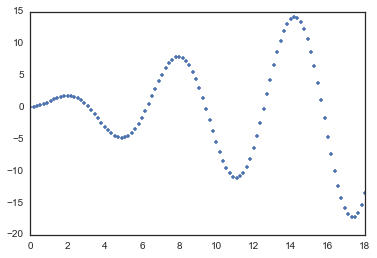

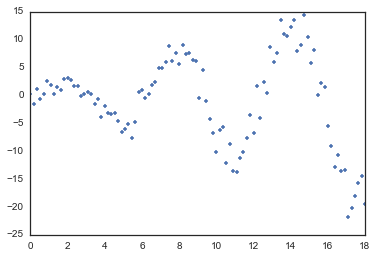

In [75]:
xx = np.linspace(0,18,100)

plt.plot(xx,f_true(xx),'.')
plt.show()

plt.plot(xx, f_noise(xx), '.')
plt.show()

Here we specify some parameters for the following experiments.

In [110]:
# Number of points we measure
N = 50
# Number of predictions in the interval
s = 100
# Number of iterations to estimate the std dev
iterations = 10

Now we look at the first strategy, sampling N points uniformly over the interval. 

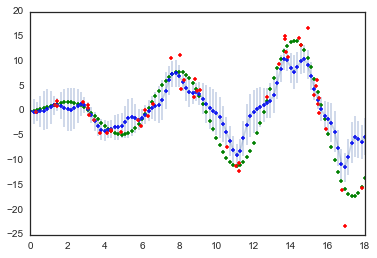

Random uniform:
Sample mean sigma: 
1.47660344233 0.0358314718746
Maximum risk: 
2.22188988757 0.0216996813352
Mean squared-prediction-error: 
13.075812004 1.56044885958


In [111]:
# ru stands for random uniform
ru_means = np.zeros(iterations)
ru_risks = np.zeros(iterations)
ru_sses = np.zeros(iterations)

# We do 100 iterations to compute the standard deviation of our results
for foo in xrange(iterations):
    #training data
    x = np.random.random(size=N) * 18
    y = f_noise(x)

    x_star = np.linspace(0,18,s) 

    mu_star, sigma_star = get_GP_mu_and_sigma_star(x, y, x_star)
    
    std_mean, risk, sse = get_evaluation(x_star, mu_star, sigma_star)
    ru_means[foo] = std_mean
    ru_risks[foo] = risk
    ru_sses[foo] = sse
    
plt.plot(x_star, f_true(x_star), 'g.')
plt.plot(x_star, mu_star, 'b.')
plt.plot(x, y, 'r.')
plt.errorbar(x_star, mu_star, yerr=1.96*np.sqrt(sigma_star.diagonal()), alpha=0.3);
plt.show()

print "Random uniform:"
print "Sample mean sigma: "
print np.mean(ru_means), np.std(ru_means)
print "Maximum risk: "
print np.mean(ru_risks), np.std(ru_risks)
print "Mean squared-prediction-error: "
print np.mean(ru_sses), np.std(ru_sses)

We see that the GP gets influenced by the measurements. We assume noise in our model, so mu_star is not required to pass directly through the measured points. Note that the confidence intervall is smaller if the GP comes close to the measured point. 
You can sometimes also observe that if the intervals between points get a bit larger the GP goes back to 0. This is because your covariance function parameters do not force much smoothness and so the measured points loose their influence very quickly. You can try and change the parameters in the Covariance function to see the effect.  

Next we look at the non random uniform sampling strategy.

Non random uniform:
Sample mean sigma: 
1.30919693589 2.22044604925e-16
Maximum risk: 
1.6889628957 0.0
Mean squared-prediction-error: 
9.09249255255 1.25136204977


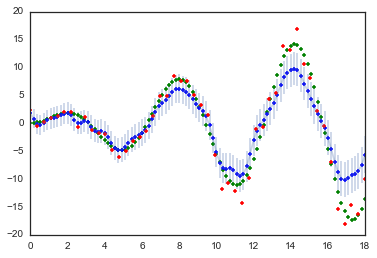

In [107]:
# GP for non random uniform samples

nru_means = np.zeros(iterations)
nru_risks = np.zeros(iterations)
nru_sses = np.zeros(iterations)

for foo in xrange(iterations):
    #training data
    x = np.linspace(0,18,N)
    y = f_noise(x)
    
    x_star = np.linspace(0,18,s) 
    
    mu_star, sigma_star = get_GP_mu_and_sigma_star(x, y, x_star)

    std_mean, risk, sse = get_evaluation(x_star, mu_star, sigma_star)
    nru_means[foo] = std_mean
    nru_risks[foo] = risk
    nru_sses[foo] = sse


plt.plot(x_star, f_true(x_star), 'g.')
plt.plot(x_star, mu_star, 'b.')
plt.plot(x, y, 'r.')
plt.errorbar(x_star, mu_star, yerr=1.96*np.sqrt(sigma_star.diagonal()), alpha=0.3);

print "Non random uniform:"
print "Sample mean sigma: "
print np.mean(nru_means), np.std(nru_means)
print "Maximum risk: "
print np.mean(nru_risks), np.std(nru_risks)
print "Mean squared-prediction-error: "
print np.mean(nru_sses), np.std(nru_sses)

With the uniform samples you can see the effect that we described before. The GP tends to go back to 0 in between measured points. 
We also see that our estimate of the pixie height improved, both visually and in the quantitative evaluation. The standard deviations of our evaluations are also smaller, as we are not inducing additional randomness anymore. 

Next we look at the sequential strategy.


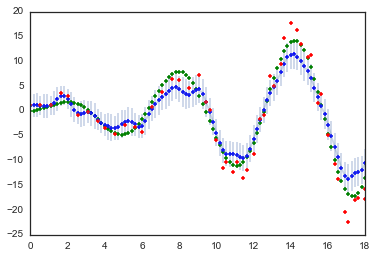

51

Sequential
Sample mean sigma: 
1.35398867293 0.0
Maximum risk: 
1.57360921019 2.22044604925e-16
Mean squared-prediction-error: 
6.30160928007 1.28963914402


In [108]:
# GP for adaptive samples
adapt_means = []
adapt_risks = []
adapt_sses = []

for foo in xrange(iterations):
    start_time = time.clock()
    #training data
    x = np.array([18.0])
    y = f_noise(x)

    #sort backwards to start at the end
    x_star = np.linspace(0,18,s)[::-1]
    
    for i in xrange(N):     
        mu_star, sigma_star = get_GP_mu_and_sigma_star(x, y, x_star)
    
        x_new = x_star[np.argmax(sigma_star.diagonal())]
        x = np.append(x, x_new)
        y = np.append(y, f_noise(x_new))
       
    std_mean, risk, sse = get_evaluation(x_star, mu_star, sigma_star)
    adapt_means.append(std_mean)
    adapt_risks.append(risk)
    adapt_sses.append(sse)
        
plt.plot(x_star, f_true(x_star), 'g.')
plt.plot(x_star, mu_star, 'b.')
plt.plot(x, y, 'r.')
plt.errorbar(x_star, mu_star, yerr=1.96*np.sqrt(sigma_star.diagonal()), alpha=0.3);
plt.show()

print len(x) # 21 is fine because the last GP estimate is from the last 20 points
print
print "Sequential"
print "Sample mean sigma: "
print np.mean(adapt_means), np.std(adapt_means)
print "Maximum risk: "
print np.mean(adapt_risks), np.std(adapt_risks)
print "Mean squared-prediction-error: "
print np.mean(adapt_sses), np.std(adapt_sses)


We compare the different strategies in a boxplot:

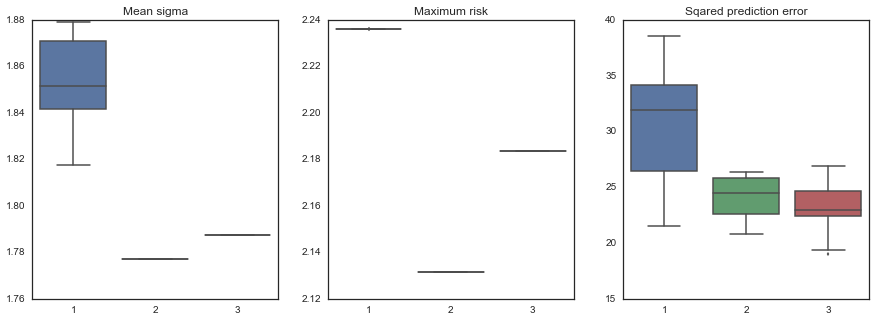

In [98]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.boxplot([ru_means, nru_means, adapt_means])
plt.title("Mean sigma")

plt.subplot(1,3,2)
sns.boxplot([ru_risks, nru_risks, adapt_risks])
plt.title("Maximum risk")

plt.subplot(1,3,3)
sns.boxplot([ru_sses, nru_sses, adapt_sses])
plt.title("Sqared prediction error")

We see that strategy 1 is not a good choice for any of the measurements. The non-random uniform measurements do very well when the task is to reduce the uncertainty of the GP, in the mean as well as in the maximum. That it performs better in reducing the maximum risk is a bit of a bummer, because our sequential design explicitly tries to minimies this criterion. If our goal is to get the best fit to the underlying true function, the sequential design looks like it is a slightly better choice. 

Next we look at the changes if we increase or decrease N. We compare the results for N=10 and N=50. I am going to be very lazy and just adjust the parameters above, run the notebook again and save the plots below. 

#### Results for N=10

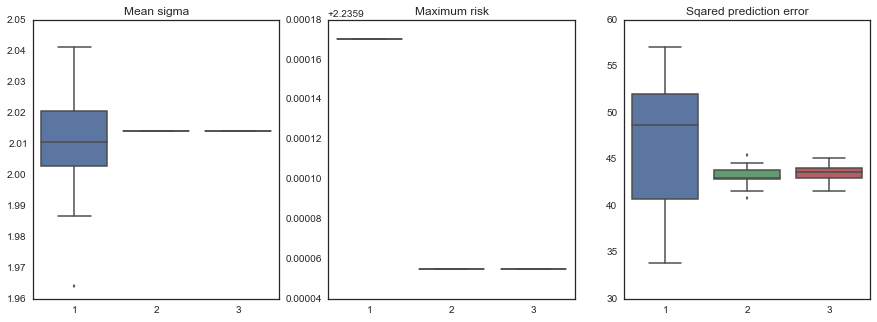

In [104]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.boxplot([ru_means, nru_means, adapt_means])
plt.title("Mean sigma")

plt.subplot(1,3,2)
sns.boxplot([ru_risks, nru_risks, adapt_risks])
plt.title("Maximum risk")

plt.subplot(1,3,3)
sns.boxplot([ru_sses, nru_sses, adapt_sses])
plt.title("Sqared prediction error")

Overall all results got worse, which is to be expected with fewer measurements. Again random sampling seems a bad choice. The difference between the non-random uniform and the sequential design is not significant. 

#### Results for N=50

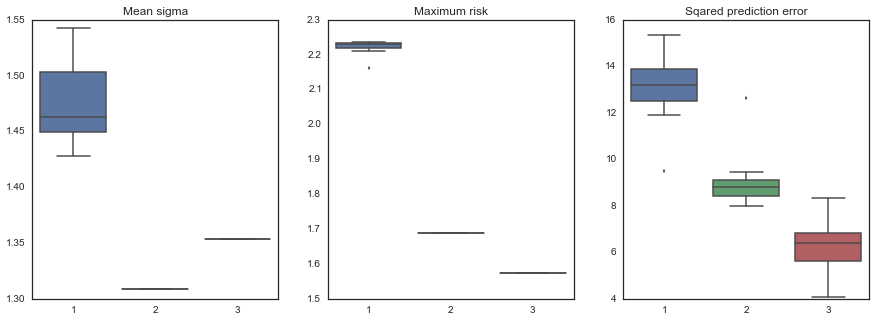

In [112]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.boxplot([ru_means, nru_means, adapt_means])
plt.title("Mean sigma")

plt.subplot(1,3,2)
sns.boxplot([ru_risks, nru_risks, adapt_risks])
plt.title("Maximum risk")

plt.subplot(1,3,3)
sns.boxplot([ru_sses, nru_sses, adapt_sses])
plt.title("Sqared prediction error")

With more points we now see that the sequential design reduces the maximum risk better than the non-random uniform design. It also gives a significant better fit to the underlying true function.